# Multiclass CNN

Classifying three types of chemicals according to their MeSH therapetutic drug class.       

<span style="float:left;">

|Drug Class|Number of Train Images|Number of Validation Images|
|:---|:---|:---|
|antineoplastic|751|350|
|cns|751|350|
|cardio|651|131|

In this notebook, I'm running 3 types of CNN models. First two models are custom built, and the last model is run on a pretrained library.

- [Model 1](#model1)
- [Model 2](#model2) 
- [Model 3](#model3) (Pretrained VGG16 library)

## Import libraries

In [43]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [44]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import layers

import os
import numpy as np
import matplotlib.pyplot as plt

%run ../assets/accuracy_loss_plots.py # function to plot accuracy and loss
%run ../assets/confusion_matrix.py # function to plot confusion matrix
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

In [46]:
pwd

'/Users/vivianpeng/git/molecular_classification/code'

## Read in Data

In [47]:
train_dir = "../train_data"
validation_dir = "../test_data"

In [48]:
num_anp_tr = len(os.listdir("../train_data/antineoplastic"))
num_cns_tr = len(os.listdir("../train_data/cns"))
num_cardio_tr = len(os.listdir("../train_data/cardio"))


num_anp_val = len(os.listdir("../test_data/antineoplastic"))
num_cns_val = len(os.listdir("../test_data/cns"))
num_cardio_val = len(os.listdir("../test_data/cardio"))

total_train = num_anp_tr + num_cns_tr
total_val = num_anp_val + num_cns_val

In [49]:
print('total training antineoplastic images:', num_anp_tr)
print('total training cns images:', num_cns_tr)
print('total training cardio images:', num_cardio_tr)

print('total validation antineoplastic images:', num_anp_val)
print('total validation cns images:', num_cns_val)
print('total validation cardio images:', num_cardio_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training antineoplastic images: 751
total training cns images: 751
total training cardio images: 657
total validation antineoplastic images: 350
total validation cns images: 350
total validation cardio images: 131
--
Total training images: 1502
Total validation images: 700


## Set up batch variables

In [50]:
batch_size = 128
epochs = 20
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [51]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [52]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode="categorical")

Found 2159 images belonging to 3 classes.


In [53]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')

Found 831 images belonging to 3 classes.


## Visualize train data

In [11]:
sample_training_images, _ = next(train_data_gen)

In [12]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

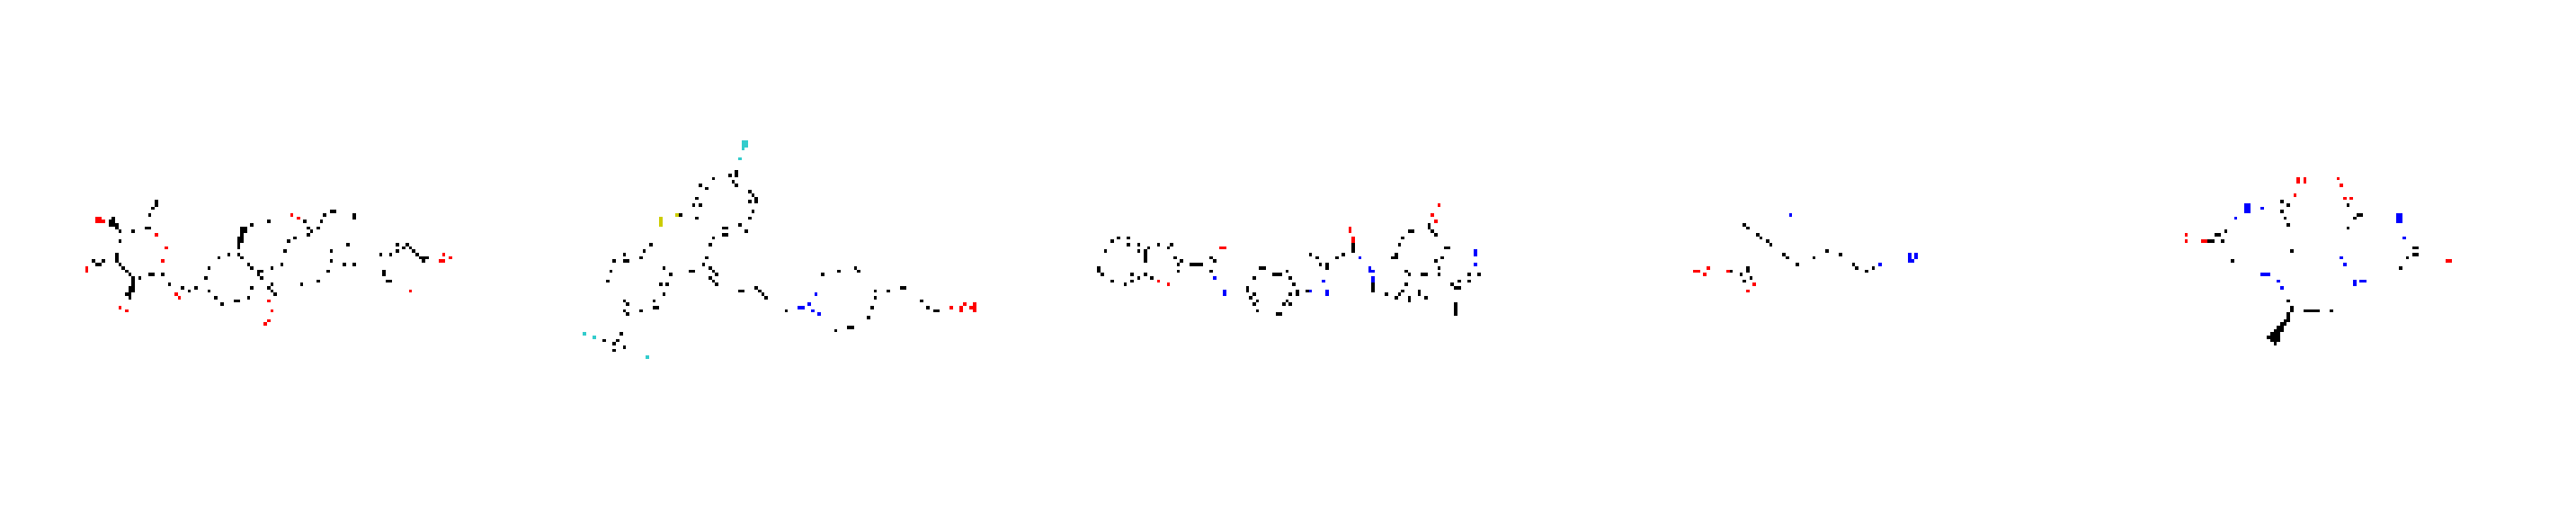

In [13]:
plotImages(sample_training_images[:5])

<a id='model1'></a>

## Model 1

This model is adapted from the tutorial on classifying cat/dog immages from TensorFlow:
https://www.tensorflow.org/tutorials/images/classification

In [14]:
model = Sequential([
    Conv2D(16, 3,  activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(3, activation = "softmax")
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [17]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/20
11/11 [==============================] - 21s 2s/step - loss: 1.3421 - accuracy: 0.3523 - val_loss: 1.0649 - val_accuracy: 0.4266
Epoch 2/20
11/11 [==============================] - 20s 2s/step - loss: 1.0830 - accuracy: 0.4076 - val_loss: 1.0129 - val_accuracy: 0.5453
Epoch 3/20
11/11 [==============================] - 17s 2s/step - loss: 1.0273 - accuracy: 0.4953 - val_loss: 1.0176 - val_accuracy: 0.4859
Epoch 4/20
11/11 [==============================] - 19s 2s/step - loss: 1.0154 - accuracy: 0.4929 - val_loss: 0.9403 - val_accuracy: 0.5531
Epoch 5/20
11/11 [==============================] - 20s 2s/step - loss: 0.9592 - accuracy: 0.5550 - val_loss: 0.9283 - val_accuracy: 0.5641
Epoch 6/20
11/11 [==============================] - 18s 2s/step - loss: 0.9129 - accuracy: 0.5701 - val_loss: 0.9212 - val_accuracy: 

### Evaluate Model

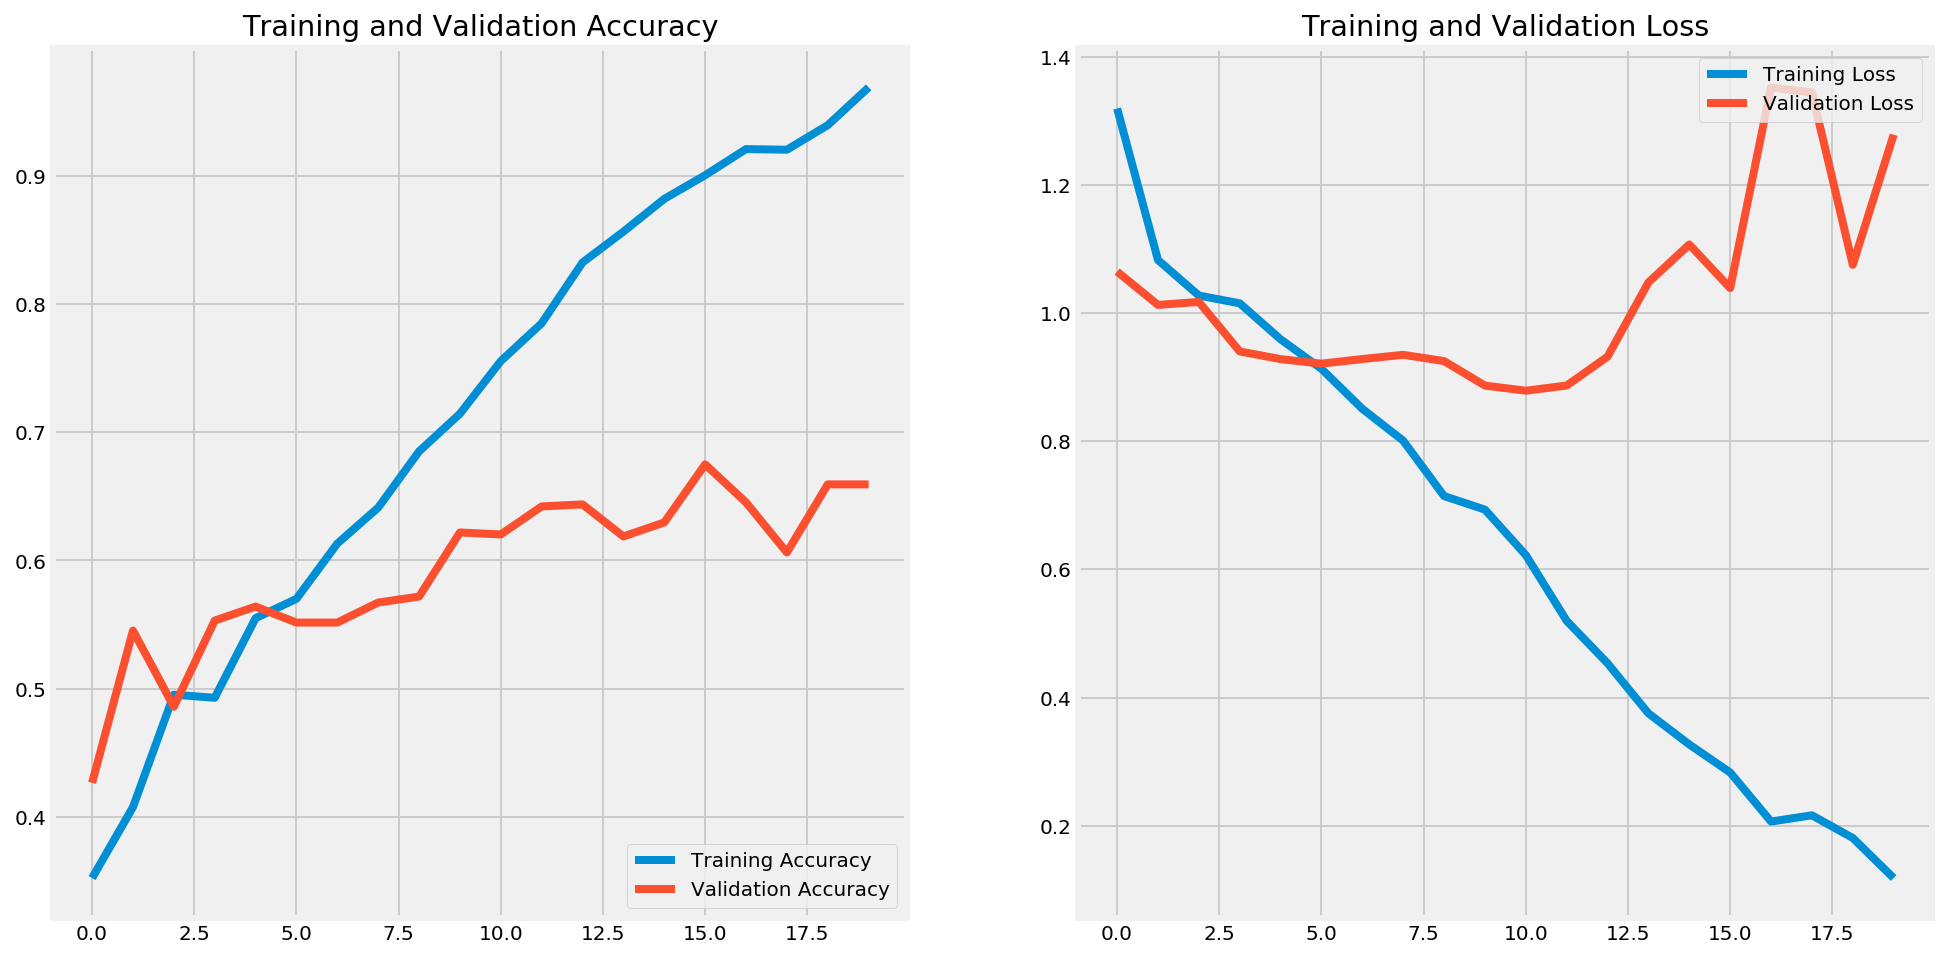

In [18]:
# evluate model 1
plot_accuracy_loss(history, epochs = 20)

<a id="model2"></a>

# Model 2

This model is adapted from the MNIST data set example in Deep Learning in Python book: https://www.manning.com/books/deep-learning-with-python

In [28]:
model2 = Sequential([
    Conv2D(16, 3,  activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation = "relu"),
    Dense(3, activation = "softmax")
])

In [29]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [30]:
history2 = model2.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/20
11/11 [==============================] - 18s 2s/step - loss: 12.1245 - accuracy: 0.3239 - val_loss: 1.9961 - val_accuracy: 0.4281
Epoch 2/20
11/11 [==============================] - 15s 1s/step - loss: 1.2875 - accuracy: 0.3853 - val_loss: 0.9675 - val_accuracy: 0.5188
Epoch 3/20
11/11 [==============================] - 15s 1s/step - loss: 0.9338 - accuracy: 0.5507 - val_loss: 0.9127 - val_accuracy: 0.5734
Epoch 4/20
11/11 [==============================] - 14s 1s/step - loss: 0.7638 - accuracy: 0.6858 - val_loss: 0.8849 - val_accuracy: 0.5672
Epoch 5/20
11/11 [==============================] - 14s 1s/step - loss: 0.5915 - accuracy: 0.7805 - val_loss: 0.8366 - val_accuracy: 0.5828
Epoch 6/20
11/11 [==============================] - 14s 1s/step - loss: 0.5131 - accuracy: 0.8152 - val_loss: 0.8791 - val_accuracy: 0.5922
Epoch 7/20
11/11 [==============================] - 17s 2s/step - lo

### Evaluate Model

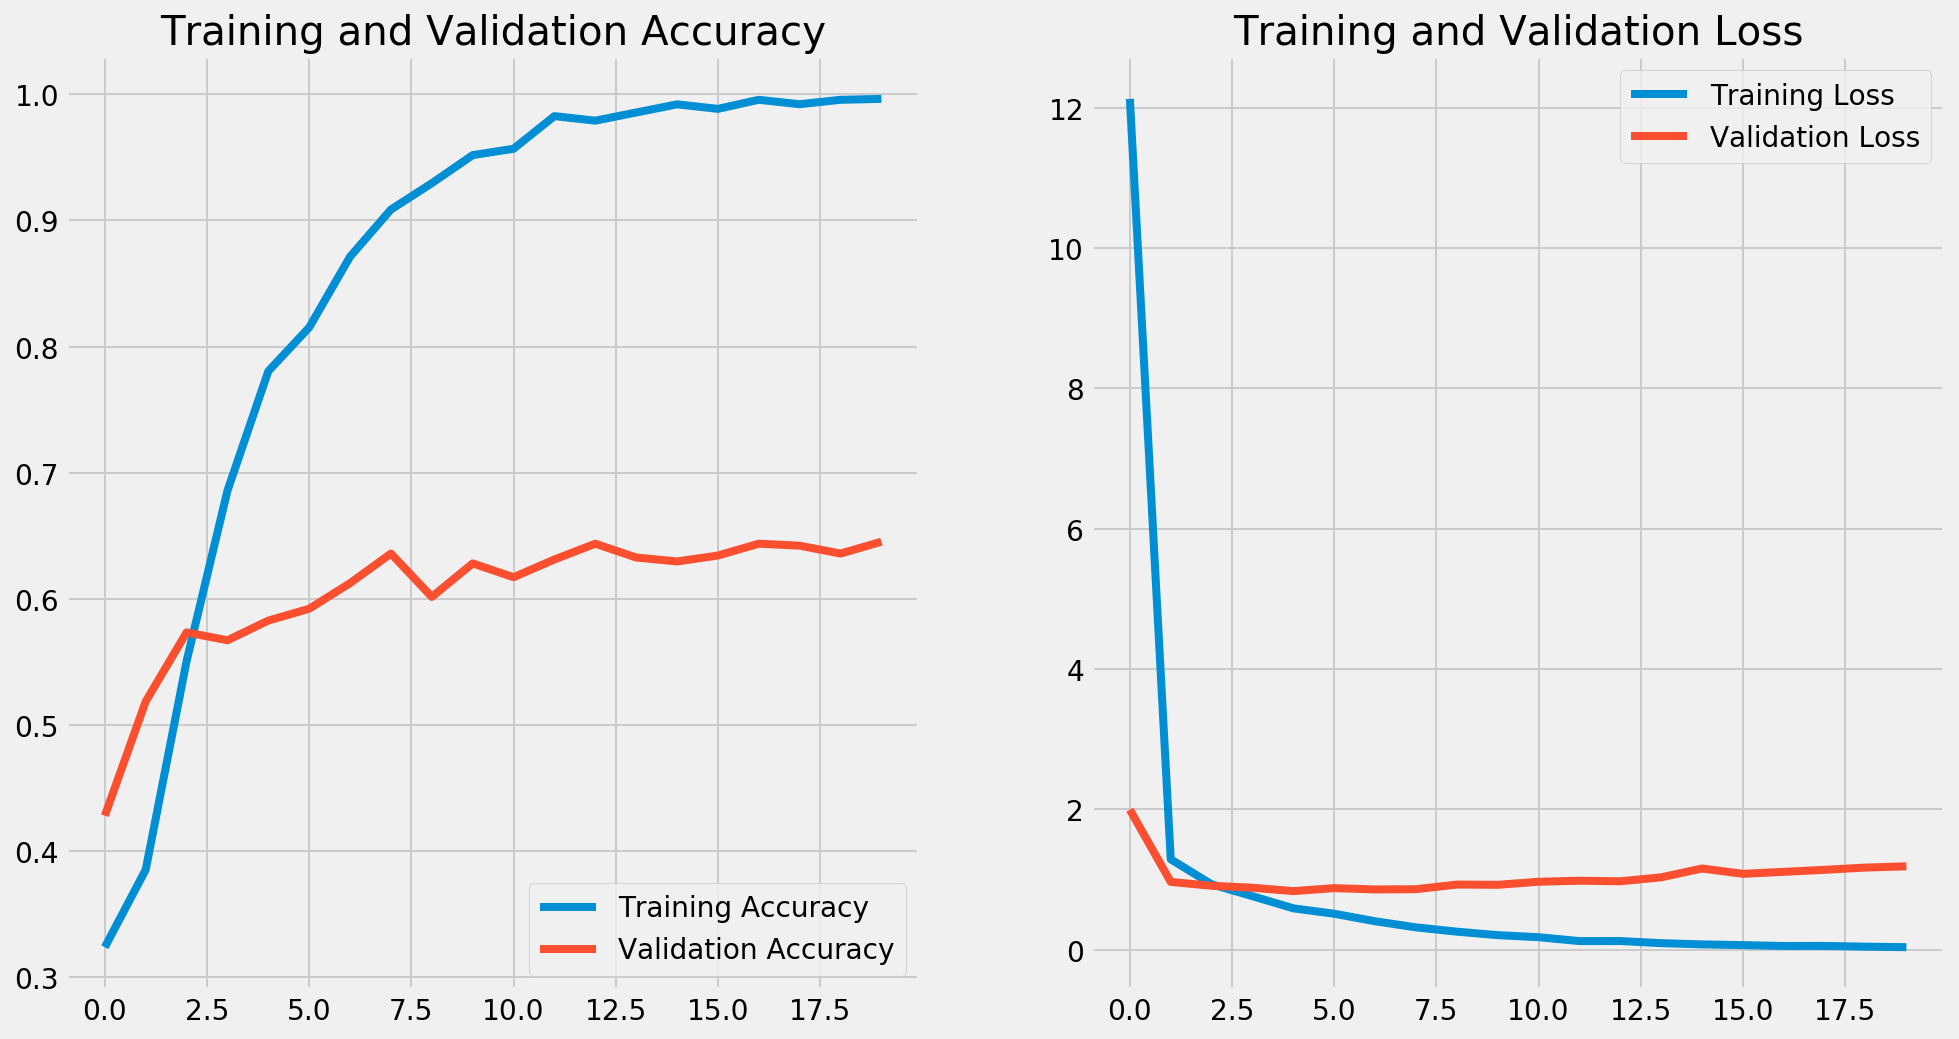

In [31]:
# evluate model 2
plot_accuracy_loss(history2, epochs = 20)

<a id="#model3"></a>

<a id="model3"></a>

# Model 3: Use a pretrained convnet

This model is adapted from the tutorial in Deep Learning in Python book: https://www.manning.com/books/deep-learning-with-python

In [54]:
conv_base = VGG16(weights = "imagenet", 
                 include_top = False,
                 input_shape = (150, 150, 3))

In [55]:
def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count, 4, 4, 512))
    labels = np.zeros(shape = (sample_count))
    generator = train_image_generator.flow_from_directory(
        directory,
        target_size = (150,150),
        batch_size = batch_size,
        class_mode = "binary"
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1)* batch_size] = features_batch
        labels[i * batch_size: (i + 1)* batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [56]:
train_features, train_labels = extract_features(train_dir, 2159)

Found 2159 images belonging to 3 classes.


In [57]:
train_labels

array([2., 1., 2., ..., 1., 0., 0.])

In [58]:
validation_features, validation_labels = extract_features(validation_dir, 831)

Found 831 images belonging to 3 classes.


In [59]:
train_features = np.reshape(train_features, (2159, 4* 4* 512))
validation_features = np.reshape(validation_features, (831, 4* 4* 512))

In [60]:
model3 = models.Sequential()
model3.add(layers.Dense(256, activation = "relu", input_dim = 4*4*512))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(3, activation = "softmax"))

In [61]:
model3.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [62]:
batch_size

128

In [65]:
history3 = model3.fit(train_features, train_labels,
                     epochs = 20,
                     batch_size = 128,
                     validation_data = (validation_features, validation_labels))

Train on 2159 samples, validate on 831 samples
Epoch 1/20
2159/2159 [==============================] - 0s 220us/sample - loss: 0.8889 - accuracy: 0.5822 - val_loss: 0.9601 - val_accuracy: 0.5295
Epoch 2/20
2159/2159 [==============================] - 0s 207us/sample - loss: 0.8976 - accuracy: 0.5785 - val_loss: 0.8794 - val_accuracy: 0.5921
Epoch 3/20
2159/2159 [==============================] - 0s 214us/sample - loss: 0.8869 - accuracy: 0.5961 - val_loss: 0.9236 - val_accuracy: 0.5740
Epoch 4/20
2159/2159 [==============================] - 0s 205us/sample - loss: 0.8809 - accuracy: 0.6035 - val_loss: 0.9005 - val_accuracy: 0.5800
Epoch 5/20
2159/2159 [==============================] - 0s 202us/sample - loss: 0.8806 - accuracy: 0.5868 - val_loss: 0.9263 - val_accuracy: 0.5511
Epoch 6/20
2159/2159 [==============================] - 0s 205us/sample - loss: 0.8639 - accuracy: 0.5975 - val_loss: 0.8787 - val_accuracy: 0.5969
Epoch 7/20
2159/2159 [==============================] - 0s 208us/

### Evaluate model

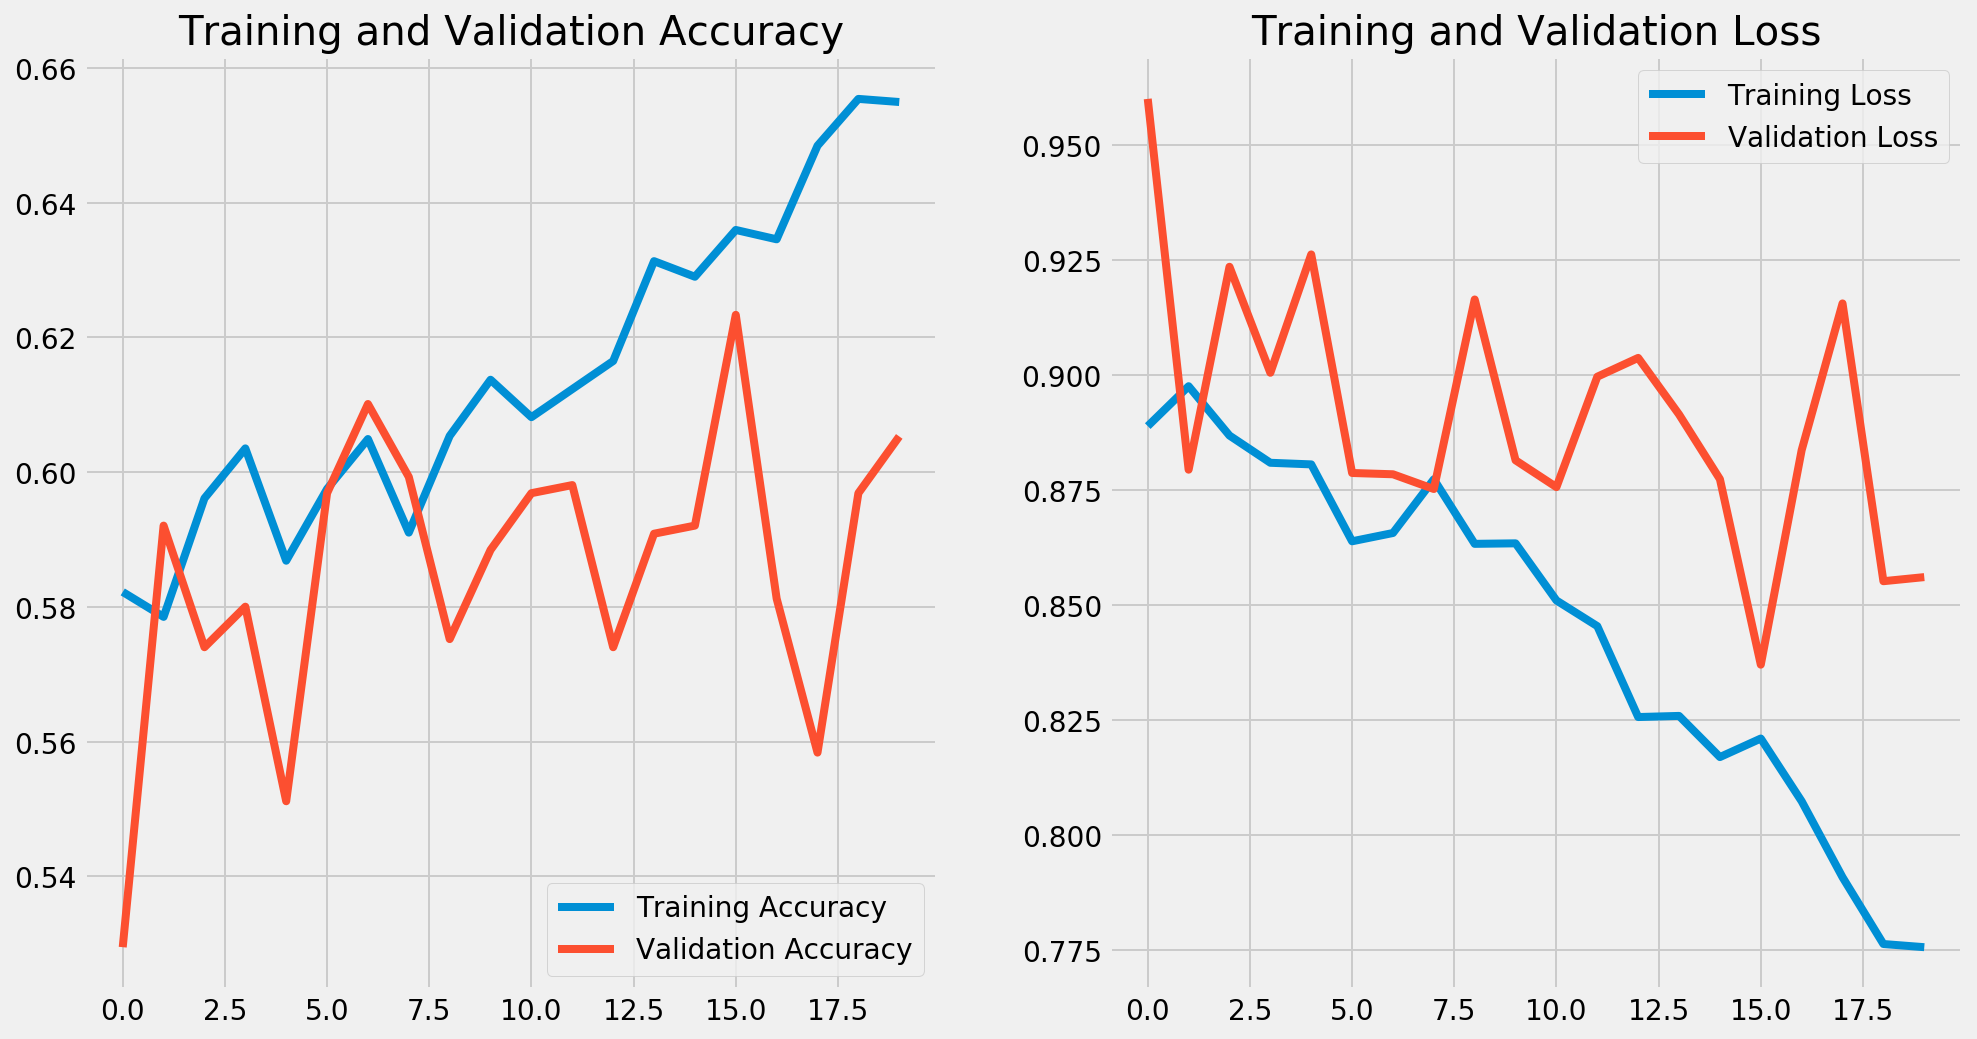

In [66]:
# evluate model 3
plot_accuracy_loss(history3, epochs = 20)

### Generate predictions

In [67]:
preds = model3.predict_classes(validation_features)

In [71]:
val_acc = round(history3.history['val_accuracy'][-1], 2)

Confusion matrix, without normalization
[[229  54  67]
 [ 47  60  24]
 [ 67  69 214]]


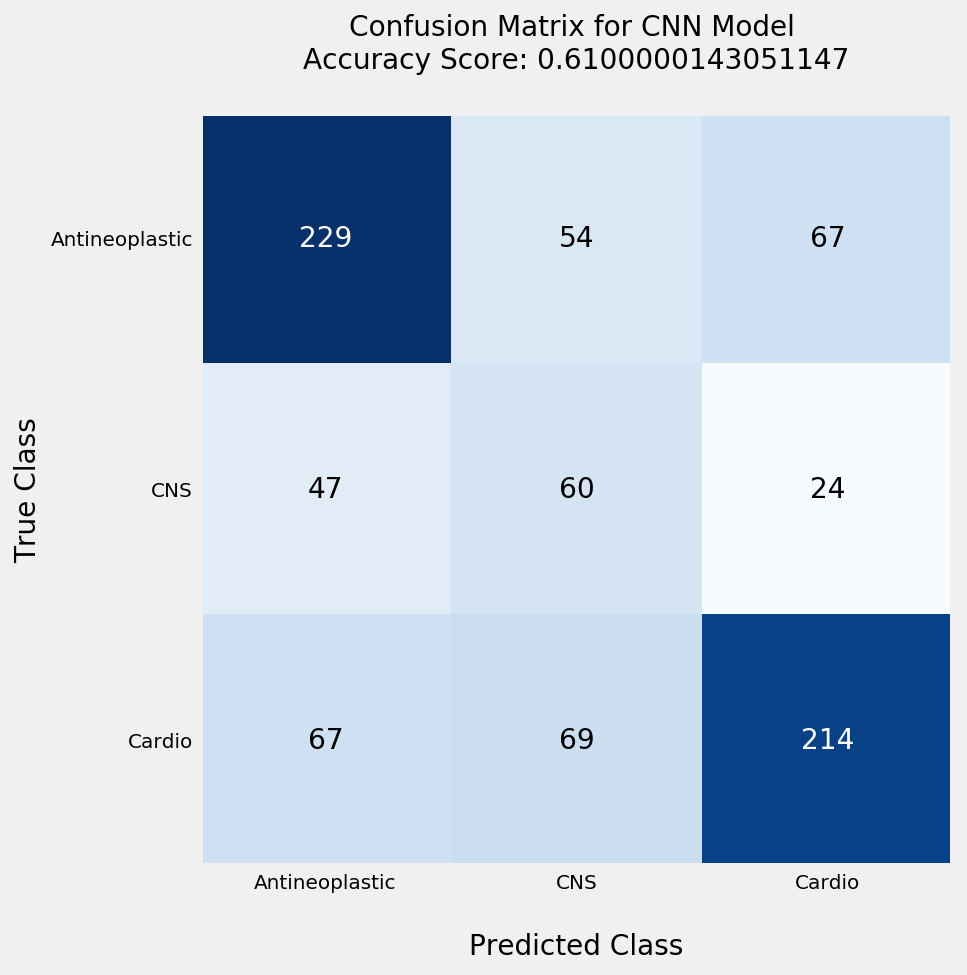

In [76]:
# Look at confusion matrix
cnf_matrix = confusion_matrix(validation_labels, preds,labels=[0, 1, 2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize = (7, 7))
plot_confusion_matrix(cnf_matrix, classes=['Antineoplastic', 'CNS', 'Cardio'],
                      title=f'Confusion Matrix for CNN Model \nAccuracy Score: {val_acc}\n' )
plt.savefig("../plots/confusion_matrix_cnn.png", dpi = 150);

### Save model

In [75]:
#save model
model3.save("../assets/model_cnn.h5")

# Conclusion

Model 3, the one using the pretrained model VGG16, is the least overfit. Models 1 and 2 have slightly higher validation scores, but are overfit to the training data.